# Protopyting Mapping 1/2

Components to Concept Examples

---
Should be similar to the crp-api to make it work with it seamlessly 

---
Input:
- Data
- Subject Model
---
Output: 
- `FeatureVisualizer`/`ConcepMap` Object

Strategies:
1. LRP use zennit-crp for this 
2. Activation -> Custom implementation
    1. Use full inputs
    2. Use latent grad resized 

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# load data
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# Load a pretrained ResNet model
model_name = "resnet50d.a1_in1k"
model = timm.create_model(model_name, pretrained=True)
model.to(device)
model.eval()


# Get the configuration for the model
config = resolve_data_config({}, model=model)

# Create the preprocessing transformation
transform = create_transform(**config)

print("Model loaded:", model_name)
print("Config:", config)
print("Transform:", transform)

Model loaded: resnet50d.a1_in1k
Config: {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.95, 'crop_mode': 'center'}
Transform: Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [3]:
# load data
import torch
from datafiles import get_dataset
from tqdm.auto import tqdm

dataset_name = "imagenet"
dataset = get_dataset(dataset_name)(split="val", transform=transform)

dataset = torch.utils.data.Subset(dataset, torch.randperm(len(dataset))[: len(dataset) // 2])

Loading imagenet


#### Review of the CRP-ZENNIT LRP implementatation

In [4]:
# the lrp way
import fnmatch
import os

from crp.attribution import CondAttribution as Attribution
from crp.concepts import ChannelConcept as Concept
from crp.visualization import FeatureVisualization
from zennit.composites import EpsilonPlusFlat as Composite
from zennit.torchvision import ResNetCanonizer

hook_point = "layer[1-4]"

hook_points = [name for name, _ in model.named_modules() if fnmatch.fnmatchcase(name, hook_point)]
print(hook_points)

cc = Concept()
layer_map = {layer_name: cc for layer_name in hook_points}

if isinstance(dataset, torch.utils.data.Subset):
    dataset_ = dataset.dataset
else:
    dataset_ = dataset

preprocess_fn = dataset_.transform
from torchvision import transforms as T

no_normalization_fn = T.Compose([t for t in preprocess_fn.transforms if not isinstance(t, T.Normalize)])
dataset_.transform = no_normalization_fn

attribution = Attribution(model)
composite = Composite([ResNetCanonizer()])
fv = FeatureVisualization(
    attribution,
    dataset,
    layer_map,
    preprocess_fn,
    max_target="sum",
    abs_norm=True,
    path="FeatureVisualization",
    device=None,
    cache=None,
)
if not os.listdir(fv.ActMax.PATH):
    fv.run(composite, 0, len(dataset), batch_size=12)
else:
    print("already computed")

['layer1', 'layer2', 'layer3', 'layer4']
already computed


In [ ]:
rfv = LrpBaseFeatureVisualization(
    attribution,
    dataset,
    layer_names=hook_points,
    preprocess_fn=preprocess_fn,
    aggregation_fn="sum",
    composite=composite,
    abs_norm=True,
    storage_dir="FeatureVisualization",
    device=None,
    cache=None,
    num_samples=40,
)

if rfv.ActMax.PATH.exists():
    print("Already computed")
else:
    rfv.run(batch_size=16, num_workers=16)

out = rfv.get_max_reference(
    concept_ids=a,  # [0],
    layer_name=hook_points[0],
    mode="activation",
    r_range=(0, 8),
    composite=composite,
    rf=False,
    batch_size=2,
)  # [0][1][1]

Already computed


In [ ]:
a = torch.tensor(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
    ]
)

out

{tensor(0): ([<PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>],
  [<PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>]),
 tensor(1): ([<PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=2

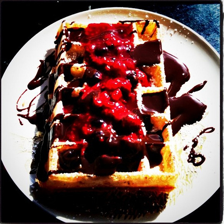

In [ ]:
from semanticlens.utils.render import crop_and_mask_images

methods = [
    "get_data_concurrently",
    "get_data_sample",
    "get_max_reference",
    "get_stats_reference",
]


fv.get_max_reference(
    concept_ids=[0],
    layer_name=hook_points[0],
    mode="relevance",
    r_range=(0, 8),
    composite=composite,
    rf=False,
    batch_size=2,
    plot_fn=crop_and_mask_images,
)[0][2]

NameError: name 'current_ids' is not defined

In [6]:
fv.get_max_reference(
    concept_ids=[0],
    layer_name=hook_points[0],
    mode="relevance",
    r_range=(0, 8),
    composite=composite,
    rf=False,
    batch_size=2,
)

{0: ([<PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>,
   <PIL.Image.Image image mode=RGB size=224x224>],
  [<PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>,
   <PIL.Image.Image image mode=P size=224x224>])}

In [ ]:
from semanticlens.utils.caching import ActMaxCache

In [7]:
import time
from collections import namedtuple
from pathlib import Path

from crp.helper import load_maximization
from crp.image import vis_img_heatmap
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

import semanticlens as sl

MaxSamples = namedtuple("MaxSamples", ["samples", "activations"])
MaxRefs = namedtuple("MaxRefs", ["sample_ids", "activations"])

DEFAULT_STORAGE = Path("cache") / "concept_examples"


class AbstractFeatureVisualization:
    def get_act_max_sample_ids(self, layer_name: str) -> sl.ConceptTensor: ...

    @property
    def layer_names(self) -> list[str]:
        return self._layer_names


class LrpBaseFeatureVisualization(AbstractFeatureVisualization, FeatureVisualization):
    def __init__(
        self,
        attribution,
        dataset,
        layer_names,
        preprocess_fn,
        composite=None,
        aggregation_fn="sum",
        abs_norm=True,
        storage_dir="FeatureVisualization",
        device=None,
        num_samples=100,
        cache=None,
    ):
        super().__init__(
            attribution,
            dataset,
            layer_map={layer_name: Concept() for layer_name in layer_names},
            preprocess_fn=preprocess_fn,
            max_target=aggregation_fn,
            abs_norm=abs_norm,
            path=storage_dir,
            device=device,
            cache=cache,
        )
        self._layer_names = layer_names

        self.num_samples = num_samples
        self.composite = composite
        self.storage_dir = storage_dir

        from crp.maximization import Maximization
        from crp.statistics import Statistics

        self.ActMax = Maximization(mode="activation", max_target=aggregation_fn, abs_norm=False, path=self.storage_dir)
        self.ActStats = Statistics(mode="activation", max_target=aggregation_fn, abs_norm=False, path=self.storage_dir)
        self.ActMax.SAMPLE_SIZE = self.num_samples

        self._ran = self.check_if_preprocessed()

    def run(
        self,
        composite: Composite = None,
        data_start=0,
        data_end=None,
        batch_size=32,
        checkpoint=500,
        on_device=None,
        **kwargs,
    ):
        composite = self._check_composite(composite)
        if not self.check_if_preprocessed():
            print("Preprocessing...")
            data_end = len(self.dataset) if data_end is None else data_end
            results = super().run(composite, data_start, data_end, batch_size, checkpoint, on_device)
            self._ran = True
            return results

        else:
            print("Already preprocessed")
            return [j for j in os.listdir(self.ActMax.PATH) if any([l in j for l in self.layer_names])]

    def get_max_reference(
        self,
        concept_ids: int | list,
        layer_name: str,
        mode="relevance",
        r_range: tuple[int, int] = (0, 8),
        composite: Composite = None,
        rf=False,
        plot_fn=vis_img_heatmap,
        batch_size=32,
    ):
        composite = self._check_composite(composite)  # [ ] TODO allow None-Composite???
        return super().get_max_reference(concept_ids, layer_name, mode, r_range, composite, rf, plot_fn, batch_size)

    def check_if_preprocessed(self):
        return bool(os.listdir(self.ActMax.PATH)) and all(
            any([i.startswith(layer_name) for i in os.listdir(self.ActMax.PATH)]) for layer_name in self.layer_names
        )

    def _check_composite(self, composite):
        assert composite or self.composite, "Composite must be provided or set in initialization (__init__)"
        return composite or self.composite

    def get_act_max_sample_ids(self, layer_name: str):
        return torch.from_numpy(load_maximization(path_folder=self.ActMax.PATH, layer_name=layer_name)[0]).T


class ActBasedFeatureVisualization(AbstractFeatureVisualization):
    def __init__(
        self,
        model,
        dataset,
        layer_names,
        storage_dir=None,
        aggregation_fn="max",
        device=None,
        num_samples=100,
        **kwargs,
    ):
        self.model = model
        self.dataset = dataset
        self._layer_names = layer_names
        self.aggregate_fn = aggregation_fn
        self.num_samples = num_samples

        if storage_dir is None:
            storage_dir = time.strftime("%Y-%m-%d_%H-%M-%S")
        self.storage_dir = DEFAULT_STORAGE / "act_based" / storage_dir

        self.actmax_cache = ActMaxCache(self.layer_names, n_collect=self.num_samples, aggregation_fn=self.aggregate_fn)
        self._ran = False

    def run(
        self,
        batch_size=32,
        num_workers=None,
        composite=None,  # [ ] TODO
        **kwargs,
    ):
        try:
            self.actmax_cache = ActMaxCache.load(self.storage_dir)
            print("Cache loaded from ", self.storage_dir)
            self._ran = True
            return
        except FileNotFoundError:
            pass

        device = next(self.model.parameters()).device
        dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
        )
        with self.actmax_cache.hook_context(self.model):
            for i, (images, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
                _ = self.model(images.to(device)).cpu()

        self.actmax_cache.store(self.storage_dir)
        print("Cache saved at ", self.storage_dir)
        self._ran = True

    def get_max(
        self,
        neuron_ids: list[int] | int,
        layer_name: str,
    ):
        assert layer_name in self.layer_names, f"Layer {layer_name} not in {self.layer_names}"
        neuron_ids = [neuron_ids] if isinstance(neuron_ids, int) else neuron_ids

        sample_ids = self.actmax_cache.cache[layer_name].sample_ids[neuron_ids]
        activations = self.actmax_cache.cache[layer_name].activations[neuron_ids]
        return {
            neuron_id: MaxRefs(sample_id, act_value)
            for neuron_id, sample_id, act_value in zip(neuron_ids, sample_ids, activations)
        }

    def get_max_all(self, layer_name):
        assert layer_name in self.layer_names, f"Layer {layer_name} not in {self.layer_names}"

        sample_ids = self.actmax_cache.cache[layer_name].sample_ids
        activations = self.actmax_cache.cache[layer_name].activations
        return MaxRefs(sample_ids, activations)

    def get_max_reference(
        self,
        neuron_ids: list[int] | int,
        layer_name: str,
        r_range: int | tuple[int, int] = (0, 25),
        return_pil: bool = True,
    ):
        # [ ] TODO act/grad-based cropping lxt like approach?
        r_range = (0, r_range) if isinstance(r_range, int) else r_range
        results = {}
        for i, (ids, acts) in tqdm(self.get_max(neuron_ids, layer_name).items()):
            samples = [to_pil_image(self.dataset[i][0]) if return_pil else self.dataset[i][0] for i in ids]
            results[i] = MaxSamples(samples, acts)

        return results

    def get_act_max_sample_ids(self, layer_name: str):
        return self.actmax_cache.cache[layer_name].sample_ids

    def __repr__(self):
        return (
            "ActBasedFeatureVisualization("
            + f"\n\tmodel={self.model.__class__.__name__},"
            + f"\n\tdataset={self.dataset.__class__.__name__},"
            + f"\n\tstorage_dir={self.storage_dir},"
            + f"\n\taggregation_fn={self.aggregate_fn},"
            + f"\n\tactmax_cache={self.actmax_cache},\n)"
        )


afv = ActBasedFeatureVisualization(
    model=model,
    dataset=dataset,
    layer_names=hook_points,
    aggregation_fn="max",
    num_samples=100,
    storage_dir="-".join([model_name, dataset_name]),
)

afv.run(batch_size=128, num_workers=16)


rfv = LrpBaseFeatureVisualization(
    attribution,
    dataset,
    layer_names=hook_points[:1],
    preprocess_fn=preprocess_fn,
    aggregation_fn="sum",
    composite=composite,
    abs_norm=True,
    storage_dir="FeatureVisualization",
    device=None,
    cache=None,
    num_samples=40,
)

if rfv.ActMax.PATH.exists():
    print("Already computed")
else:
    rfv.run(batch_size=16, num_workers=16)

NameError: name 'ActMaxCache' is not defined

In [9]:
out = afv.get_max_reference([1, 25, 213], "layer1", return_pil=True)

100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


In [ ]:
import json

import einops
from torch.nn.functional import normalize

from semanticlens import ConceptTensor


class CustomDataset(torch.utils.data.Dataset):
    # [ ] rewrite this!
    def __init__(self, data_pil_list, processor=None):
        self.data_pil_list = data_pil_list
        self.processor = processor
        self.length = len(data_pil_list)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # for key in self.keys:
        sample = self.data_pil_list[idx]
        if self.processor:
            sample = self.processor(images=self.data_pil_list[idx], return_tensors="pt")
            return sample["pixel_values"].squeeze()

        return sample.squeeze()


class Lens:
    """
    A class for visual concept analysis and exploration.

    Lens provides methods to embed images and text datasets for semantic analysis.
    It integrates feature visualization (fv) with foundation models (fm) to
    explore relationships between visual concepts and text embeddings.

    Methods:
        embed_text_dataset: Embeds a list of text concepts, applying templates if provided.
        embed_text: Embeds a single text prompt.
        embed_image_dataset: Embeds an image dataset using the foundation model.
    """

    def __init__(
        self,
        dataset,
        fv,
        fm,
        fm_preprocessor,
        dataset_name,
        fm_name,
        storage_dir,
        device=None,
    ):
        self.dataset = dataset
        self.fv = fv
        self.fm = fm
        self.fm_preprocessor = fm_preprocessor
        self.layer_names = fv.layer_names
        self.fm_name = fm_name
        self.dataset_name = dataset_name
        self.device = device or next(self.fm.parameters()).device
        self.storage_dir = storage_dir

    def embed_text_dataset(self, texts: list, templates: list = ["an image of {}"], batch_size=32, cache=True):
        texts = sorted(texts)
        metadata = {"texts": texts, "templates": templates, "fm": self.fm_name}

        if cache:
            hash_val = hash(json.dumps(metadata, sort_keys=True))
            fpath_ = Path(self.storage_dir) / "text_embeds" / self.fm.name / f"{hash_val}.safetensors"
            if fpath_.exists():
                text_embeds = ConceptTensor.load(fpath_)
                if (
                    text_embeds.metadata["fm"] == self.fm_name
                    and text_embeds.metadata["texts"] == texts
                    and text_embeds.metadata["templates"] == templates
                ):
                    print("Loaded from cache.")
                    return text_embeds, texts
                else:
                    print("Cache mismatch, recomputing!")
            else:
                print("Cache not found (", fpath_, ")")

        labels = [t.format(l) for t in templates or ["{}"] for l in texts]

        if templates:
            empty = [t.format("") for t in templates]
            empty_embeds = self.embed_text(empty, templates=None, device=device)

        text_embeds = []
        for i in tqdm(range(0, len(labels), batch_size), desc="Embedding texts"):
            batch = labels[i : i + batch_size]
            text_embed = self.embed_text(batch, templates=None, device=device)
            text_embeds.append(text_embed)
        text_embeds = torch.cat(text_embeds, dim=0)

        if templates is None:
            return text_embeds, texts

        text_embeds = (
            einops.rearrange(
                text_embeds, "(d_temp d_txt) d_emb -> d_txt d_temp d_emb", d_txt=len(texts), d_temp=len(templates)
            )
            - empty_embeds[None]  # remove empty templates ...
        ).mean(1)  # ... and average over them

        # [ ] TODO do not normalize?
        text_embeds = normalize(text_embeds, p=2, dim=-1)
        text_embeds = ConceptTensor(text_embeds, metadata=metadata)

        if cache:
            fpath_.parent.mkdir(parents=True, exist_ok=True)
            print("store in ", fpath_)
            text_embeds.save(fpath_)

        return text_embeds, texts

    @torch.no_grad()
    def embed_text(self, text, templates=None, device="cpu"):
        self.fm.to(device)
        if not templates:
            return self.fm(text=self.fm.text_preprocessing(text).to(device))[1]

        assert isinstance(templates, list)

        text = [t.format(text) for t in templates]
        text_embed = self.fm(text=self.fm.text_preprocessing(text).to(device))[1]

        empty = [t.format("") for t in templates]
        empty_embed = self.fm(text=self.fm.text_preprocessing(empty).to(device))[1]

        # correct embedding
        text_embed = text_embed - empty_embed

        return text_embed.mean(0).unsqueeze(0)

    @torch.no_grad()
    def embed_image_dataset(self, batch_size=32, device=None, cache=True, **dataloader_kwargs) -> ConceptTensor:
        if isinstance(self.dataset, torch.utils.data.Subset):
            dataset_ = self.dataset.dataset
            data_ids = self.dataset.indices.tolist()
        else:
            dataset_ = self.dataset
            data_ids = list(range(len(dataset_)))
        dataset_.transform = self.fm.image_preprocessing  # [ ] TODO avoid inplace operation due to side-effects!

        fpath_ = Path(self.storage_dir) / "image_embeds" / self.fm.name / f"{self.dataset_name}.safetensors"
        if cache:
            if fpath_.exists():
                dataset_embeds = ConceptTensor.load(fpath_)
                if (
                    dataset_embeds.metadata["fm"] == self.fm_name
                    and dataset_embeds.metadata["dataset"] == self.dataset_name
                    and dataset_embeds.metadata["ids"] == data_ids
                ):
                    print("Loaded from cache.")
                    return dataset_embeds
                else:
                    print("Cache mismatch, recomputing!")

        dataloader = torch.utils.data.DataLoader(
            dataset_,
            batch_size=batch_size,
            shuffle=False,
            **dataloader_kwargs,
        )

        if device is not None:
            self.fm.to(device)

        embeds = []
        for batch in tqdm(dataloader, total=len(dataloader)):
            data = batch[0] if isinstance(batch, (tuple, list)) else batch

            if device is not None:
                data = data.to(device)

            fm_out = self.fm(data)[0].cpu()
            embeds.append(fm_out)

        dataset_embeds = ConceptTensor(
            torch.cat(embeds, dim=0),
            metadata={"fm": self.fm_name, "dataset": self.dataset_name, "ids": data_ids},
        )

        if cache:
            fpath_.parent.mkdir(parents=True, exist_ok=True)
            print("store in ", fpath_)
            dataset_embeds.save(fpath_)

        return dataset_embeds

    def compute_semantic_embeddigs(
        self,
        layer_names: list[str] | str,
        component_specific_examples: bool = False,
        batch_size: int = 32,
        device: str = None,
        cache=True,
        dataloader_kwargs: dict = {},
        **kwargs,
    ) -> dict[str, ConceptTensor]:
        """
        Compute semantic embeddings for the specified layers.

        This method takes a set of layer names and computes semantic embeddings for each layer.
        Two modes are supported:
        - "full_input": First embeds each input sample, then constructs specific embeddings
        - "component_specific": Directly computes embeddings for specific components

        Args:
            layer_names: List of layer names or a single layer name string
            example_mode: Mode to compute embeddings ("full_input" or "component_specific")
            batch_size: Batch size for processing
            device: Device to use for computation
            cache: Whether to use cached embeddings
            dataloader_kwargs: Additional arguments to pass to the DataLoader
            **kwargs: Additional arguments for component-specific embedding computation

        Returns:
            Dictionary mapping layer names to their semantic embeddings as ConceptTensors
        """

        print(kwargs)  # TODO remove!

        if component_specific_examples:
            return self.compute_component_specific_embeddings(
                layer_names=layer_names,
                batch_size=batch_size,
                device=device,
                cache=cache,
                dataloader_kwargs=dataloader_kwargs,
            )

        # full_input -> first embed each input sample -> second construct specific embeddings
        # TODO could be improved by only embedding the necessary images (too much overhead for now)
        dataset_embeddings = self.embed_image_dataset(
            batch_size=batch_size,
            device=batch_size,
            cache=cache,
            **dataloader_kwargs,
        )
        self.full_concept_db = {}
        for layer_name in layer_names:
            self.full_concept_db[layer_name] = dataset_embeddings[self.fv.get_act_max_sample_ids(layer_name)]
        return self.full_concept_db

        # component_specific

    @torch.no_grad()
    def compute_component_specific_embeddings(
        self, layer_names, batch_size, composite=None, n_ref=None, rf=True, **kwargs
    ) -> dict[str, ConceptTensor]:
        print(kwargs)  # TODO remove!
        self.full_concept_db = {}
        for layer_name in tqdm(layer_names):
            n_components, n_ref_ = self.fv.get_act_max_sample_ids(layer_name).shape
            n_ref = n_ref or n_ref_
            component_ids = torch.arange(n_components)
            layer_embeddings = []

            for batch_id in tqdm(range(0, len(component_ids), batch_size), leave=False):
                current_ids = component_ids[batch_id : batch_id + batch_size]

                # [ ] TODO unify this to also work with gradient based localisation!
                concept_example_dict = self.fv.get_max_reference(
                    concept_ids=current_ids.tolist(),
                    layer_name=layer_name,
                    mode="activation",
                    r_range=(0, n_ref),
                    composite=composite,
                    rf=rf,
                    batch_size=n_ref,  # FIXME Max said there is a bug here in crp code which is it? fix it!
                )
                concept_examples_pil = [ex for cpt_exs in concept_example_dict.values() for ex in cpt_exs]
                for pil_batch_id in tqdm(range(0, len(concept_examples_pil), batch_size), leave=False):
                    pil_batch = concept_examples_pil[pil_batch_id : pil_batch_id + batch_size]

                    out = self.fm(self.fm_preprocessor(image=pil_batch, return_tensors="pt")["image"].to(device))[
                        0
                    ].cpu()

                    layer_embeddings.append(
                        einops.arrange(
                            out, "(n_components n_ref) dim_emb -> n_components n_ref dim_emb", n_components=n_components
                        )
                    )
            self.full_concept_db[layer_name] = torch.cat(layer_embeddings, dim=0)
        return self.full_concept_db


from semanticlens.foundation_models.clip import ClipMobile

fm = ClipMobile("MobileCLIP-S1")

lens = Lens(
    dataset=dataset.dataset,
    fv=rfv,
    fm=fm,
    fm_preprocessor=fm.processor,
    dataset_name=dataset_name,
    storage_dir=Path("cache"),
    fm_name=model_name,
)
lens.compute_semantic_embeddigs(["layer1"], component_specific_examples=True)

{}
{'device': None, 'cache': True, 'dataloader_kwargs': {}}


  0%|          | 0/1 [01:20<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'register_hook'

In [ ]:
# deviding templates and texts
import torch

texts = [torch.ones(1, 3), -torch.ones(1, 3)]
templates = range(1, 5)
data = [t * txt for t in templates for txt in texts]  # 1: temp , 2: text
data = torch.cat(data, dim=0)
#                               ┌─ 1.     ┌─ 2.
tmp = einops.rearrange(data, "(d_temp d_txts) w -> d_txts d_temp w", d_temp=len(templates), d_txts=len(texts))
tmp.mean(1)

tensor([[ 2.5000,  2.5000,  2.5000],
        [-2.5000, -2.5000, -2.5000]])

In [ ]:
from semanticlens.foundation_models.clip import ClipMobile

fm = ClipMobile("MobileCLIP-S1")

In [ ]:
lens = Lens(
    dataset=dataset.dataset,
    fv=afv,
    fm=fm,
    fm_preprocessor=fm.processor,
    dataset_name=dataset_name,
    storage_dir=Path("cache"),
    fm_name=model_name,
)

In [ ]:
# image dataset embedding
embed_image_dataset = lens.embed_image_dataset(
    batch_size=32,
    num_workers=16,
    device=device,
    cache=True,
)

Loaded from cache.


#### how to construct the embeddings?

unify the api of the methods: act-based and rel-based

```
def get_act_max_sample_ids(self, layer_name) -> ConceptTensor: ...

```

In [ ]:
# via actmax cache

embed_image_dataset.shape
print(afv.actmax_cache.cache["layer1"].sample_ids.shape)

# via rel crp


d_c_sorted, _, rf_c_sorted = load_maximization(fv.ActMax.PATH, layer_name="layer1")
d_c_sorted.shape


act_max_samples = afv.actmax_cache.cache["layer1"].sample_ids
embed_image_dataset

# get_act_max_sample_ids(layer_name):

torch.Size([256, 100])


ConceptTensor(ConceptTensor([[ 0.0332, -0.0654, -0.0368,  ..., -0.0079, -0.0310, -0.0306],
               [ 0.0383, -0.0294, -0.0406,  ..., -0.0187, -0.0039,  0.0117],
               [ 0.0228, -0.0298, -0.0248,  ...,  0.0657,  0.0236,  0.0290],
               ...,
               [-0.0160, -0.0264,  0.0665,  ...,  0.0266, -0.0183, -0.0220],
               [-0.0046, -0.0349,  0.0429,  ...,  0.0558,  0.0100,  0.0326],
               [-0.0596, -0.0505,  0.0195,  ...,  0.0484, -0.0392, -0.0998]]),
              metadata={ "dataset": "imagenet", "fm": "resnet50d.a1_in1k", "ids": [...})

final product:

In [ ]:
lens.compute_semantic_embeddigs(["layer1", "layer2"], component_specific_examples=True)

{}
{'component_specific_examples': True, 'device': None, 'cache': True, 'dataloader_kwargs': {}}


  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: arange() received an invalid combination of arguments - got (), but expected one of:
 * (Number end, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Number end, *, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Number end, Number step = 1, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [ ]:
embed_image_dataset[act_max_samples].shape
# act_max_samples.shape

torch.Size([256, 100, 512])

In [ ]:
embed_image_dataset[torch.from_numpy(d_c_sorted).T].shape

torch.Size([256, 40, 512])

In [ ]:
# stress test
import os

import requests

# Define the URL and the local file path
url = "https://huggingface.co/datasets/huggingface/label-files/resolve/main/imagenet-22k-id2label.json"
local_path = "/data/labels"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(local_path), exist_ok=True)

# Fetch the JSON data from the URL
response = requests.get(url)
response.raise_for_status()

In [ ]:
[t for t in "sick" or [1, 2, 3]]

['s', 'i', 'c', 'k']

In [ ]:
import semanticlens as sl

a = sl.ConceptTensor(torch.rand(12, 1200))
a
# torch._tensor_str._str(self, tensor_contents=tensor_contents)
# print(torch._tensor_str._str(torch.rand(12,12)))
a.__repr__()[len(type(a).__name__) + 1 : -2]

'ConceptTensor([[0.4895, 0.4176, 0.3831,  ..., 0.9215, 0.3024, 0.7342],\n               [0.7597, 0.3142, 0.8997,  ..., 0.7956, 0.9699, 0.2385],\n               [0.0939, 0.7845, 0.7785,  ..., 0.1251, 0.2503, 0.0799],\n               ...,\n               [0.5727, 0.9431, 0.7122,  ..., 0.9611, 0.3379, 0.0368],\n               [0.1810, 0.0275, 0.5475,  ..., 0.6702, 0.0028, 0.4530],\n               [0.7467, 0.5046, 0.0483,  ..., 0.4027, 0.4591, 0.7043]]),\n              metadata={'

In [ ]:
attribution.model.to("cpu")

next(attribution.model.parameters()).device

device(type='cpu')

: 